<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BCuiab%C3%A1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/cuiabadiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,21896.0,21896.000000,10880.000000,10618.000000,10573.000000,9723.000000,7750.000000,10297.000000,8700.000000,7785.000000,0.0
mean,83361.0,599.287541,4.096682,33.105415,21.504899,6.233714,4.288658,26.233652,73.339195,1.511859,NaN
std,0.0,600.013279,11.289206,3.557587,3.228591,3.336297,2.441899,2.761905,11.875783,0.767093,NaN
min,83361.0,0.000000,0.000000,9.800000,4.800000,0.000000,0.000000,10.800000,25.750000,0.000000,NaN
25%,83361.0,0.000000,0.000000,31.600000,19.800000,3.600000,2.500000,25.180000,66.000000,1.000000,NaN
50%,83361.0,0.000000,0.000000,33.600000,22.500000,6.900000,3.900000,26.640000,74.750000,1.371840,NaN
75%,83361.0,1200.000000,1.400000,35.200000,23.800000,9.100000,5.600000,27.900000,82.250000,1.900000,NaN
max,83361.0,1200.000000,134.300000,42.300000,29.400000,12.700000,31.400000,33.440000,100.000000,6.666667,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83361,1980-01-01,0,NaN,28.4,NaN,10.2,1.3,23.88,66.75,1.766667,NaN
1,83361,1980-01-01,1200,5.3,NaN,20.4,NaN,NaN,NaN,NaN,NaN,NaN
2,83361,1980-01-02,0,NaN,30.4,NaN,11.2,4.1,24.68,NaN,1.733333,NaN
3,83361,1980-01-02,1200,0.0,NaN,19.2,NaN,NaN,NaN,NaN,NaN,NaN
4,83361,1980-01-03,0,NaN,33.6,NaN,10.7,4.3,26.40,NaN,1.000000,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,10618.000000,0.0,9723.000000,7750.000000,10297.000000,8700.000000,7785.000000
mean,NaN,33.105415,NaN,6.233714,4.288658,26.233652,73.339195,1.511859
std,NaN,3.557587,NaN,3.336297,2.441899,2.761905,11.875783,0.767093
min,NaN,9.800000,NaN,0.000000,0.000000,10.800000,25.750000,0.000000
25%,NaN,31.600000,NaN,3.600000,2.500000,25.180000,66.000000,1.000000
50%,NaN,33.600000,NaN,6.900000,3.900000,26.640000,74.750000,1.371840
75%,NaN,35.200000,NaN,9.100000,5.600000,27.900000,82.250000,1.900000
max,NaN,42.300000,NaN,12.700000,31.400000,33.440000,100.000000,6.666667


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,10880.000000,0.0,10573.000000,0.0,0.0,0.0,0.0,0.0
mean,4.096682,NaN,21.504899,NaN,NaN,NaN,NaN,NaN
std,11.289206,NaN,3.228591,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,4.800000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,19.800000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,22.500000,NaN,NaN,NaN,NaN,NaN
75%,1.400000,NaN,23.800000,NaN,NaN,NaN,NaN,NaN
max,134.300000,NaN,29.400000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,28.4,10.2,1.3,23.88,66.75,1.766667
1980-01-02,30.4,11.2,4.1,24.68,NaN,1.733333
1980-01-03,33.6,10.7,4.3,26.40,NaN,1.000000
1980-01-04,35.2,11.5,3.8,28.52,NaN,1.300000
1980-01-05,34.2,6.6,6.2,27.64,NaN,1.933333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,5.3,20.4
1980-01-02,0.0,19.2
1980-01-03,0.0,20.2
1980-01-04,0.0,22.2
1980-01-05,0.0,24.6


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,28.4,10.2,1.3,23.88,66.75,1.766667,5.3,20.4
1980-01-02,30.4,11.2,4.1,24.68,NaN,1.733333,0.0,19.2
1980-01-03,33.6,10.7,4.3,26.40,NaN,1.000000,0.0,20.2
1980-01-04,35.2,11.5,3.8,28.52,NaN,1.300000,0.0,22.2
1980-01-05,34.2,6.6,6.2,27.64,NaN,1.933333,0.0,24.6


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,10618.000000,9723.000000,7750.000000,10297.000000,8700.000000,7785.000000,10880.000000,10573.000000
mean,33.105415,6.233714,4.288658,26.233652,73.339195,1.511859,4.096682,21.504899
std,3.557587,3.336297,2.441899,2.761905,11.875783,0.767093,11.289206,3.228591
min,9.800000,0.000000,0.000000,10.800000,25.750000,0.000000,0.000000,4.800000
25%,31.600000,3.600000,2.500000,25.180000,66.000000,1.000000,0.000000,19.800000
50%,33.600000,6.900000,3.900000,26.640000,74.750000,1.371840,0.000000,22.500000
75%,35.200000,9.100000,5.600000,27.900000,82.250000,1.900000,1.400000,23.800000
max,42.300000,12.700000,31.400000,33.440000,100.000000,6.666667,134.300000,29.400000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,28.4,10.2,1.3,23.88,66.75,1.766667,5.3,20.4
1980-01-02,30.4,11.2,4.1,24.68,NaN,1.733333,0.0,19.2
1980-01-03,33.6,10.7,4.3,26.40,NaN,1.000000,0.0,20.2
1980-01-04,35.2,11.5,3.8,28.52,NaN,1.300000,0.0,22.2
1980-01-05,34.2,6.6,6.2,27.64,NaN,1.933333,0.0,24.6


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,10.2,1.3,23.88,66.75,1.766667,5.3,20.4
1980-01-02,11.2,4.1,24.68,NaN,1.733333,0.0,19.2
1980-01-03,10.7,4.3,26.40,NaN,1.000000,0.0,20.2
1980-01-04,11.5,3.8,28.52,NaN,1.300000,0.0,22.2
1980-01-05,6.6,6.2,27.64,NaN,1.933333,0.0,24.6


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    28.4
1980-01-02    30.4
1980-01-03    33.6
1980-01-04    35.2
1980-01-05    34.2
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,9542.000000,7596.000000,10293.000000,8522.000000,7603.000000,10541.000000,10385.000000
mean,-0.015235,-0.724733,0.363462,0.281965,-0.544352,-0.939211,0.354974
std,0.525518,0.155487,0.243952,0.321091,0.230763,0.168576,0.262270
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.433071,-0.840764,0.270318,0.077441,-0.700000,-1.000000,0.211382
50%,0.102362,-0.751592,0.399293,0.319865,-0.580000,-1.000000,0.430894
75%,0.448819,-0.643312,0.510601,0.521886,-0.430000,-0.979151,0.536585
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(10618, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 879.1186 - mean_absolute_error: 29.3570
Epoch 2/200
 - 1s - loss: 565.3861 - mean_absolute_error: 23.4616
Epoch 3/200
 - 1s - loss: 357.7826 - mean_absolute_error: 18.5263
Epoch 4/200
 - 1s - loss: 213.0427 - mean_absolute_error: 14.1122
Epoch 5/200
 - 1s - loss: 117.1481 - mean_absolute_error: 10.2576
Epoch 6/200
 - 1s - loss: 59.2576 - mean_absolute_error: 7.0868
Epoch 7/200
 - 1s - loss: 29.2062 - mean_absolute_error: 4.7842
Epoch 8/200
 - 1s - loss: 16.9340 - mean_absolute_error: 3.4185
Epoch 9/200
 - 1s - loss: 13.4359 - mean_absolute_error: 2.8312
Epoch 10/200
 - 1s - loss: 12.8359 - mean_absolute_error: 2.6548
Epoch 11/200
 - 1s

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -2.269355, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-2.269355 (0.080287) {'batch_size': 10, 'camadas': 2, 'units': 7}


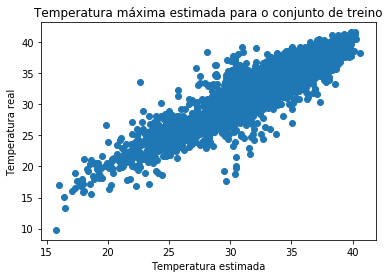

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.        0.9093326]
 [0.9093326 1.       ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

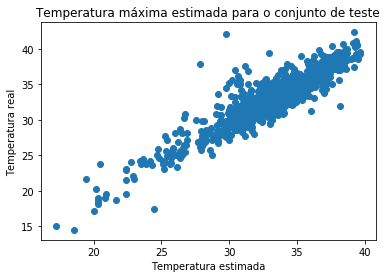

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.90798099]
 [0.90798099 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

1.0954108020904598


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

2.315848505870017


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,28.4,10.2,1.3,23.88,66.75,1.766667,5.3
1980-01-02,30.4,11.2,4.1,24.68,NaN,1.733333,0.0
1980-01-03,33.6,10.7,4.3,26.40,NaN,1.000000,0.0
1980-01-04,35.2,11.5,3.8,28.52,NaN,1.300000,0.0
1980-01-05,34.2,6.6,6.2,27.64,NaN,1.933333,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    20.4
1980-01-02    19.2
1980-01-03    20.2
1980-01-04    22.2
1980-01-05    24.6
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,10385.000000,9547.000000,7573.000000,10231.000000,8472.000000,7549.000000,10518.000000
mean,0.434014,-0.014263,-0.724684,0.362973,0.279270,-0.545380,-0.939671
std,0.219951,0.524648,0.155669,0.244524,0.320751,0.230098,0.167755
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.341538,-0.433071,-0.840764,0.270318,0.077441,-0.700000,-1.000000
50%,0.464615,0.102362,-0.751592,0.399293,0.319865,-0.580000,-1.000000
75%,0.563077,0.433071,-0.643312,0.510601,0.521886,-0.430000,-0.979151
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(10573, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 327.4330 - mean_absolute_error: 17.6857
Epoch 2/200
 - 1s - loss: 158.5615 - mean_absolute_error: 12.0984
Epoch 3/200
 - 1s - loss: 73.4109 - mean_absolute_error: 7.9726
Epoch 4/200
 - 1s - loss: 31.8308 - mean_absolute_error: 5.0630
Epoch 5/200
 - 1s - loss: 15.6313 - mean_absolute_error: 3.4580
Epoch 6/200
 - 1s - loss: 11.2233 - mean_absolute_error: 2.8216
Epoch 7/200
 - 1s - loss: 10.5146 - mean_absolute_error: 2.6207
Epoch 8/200
 - 1s - loss: 10.4256 - mean_absolute_error: 2.5730
Epoch 9/200
 - 1s - loss: 10.4078 - mean_absolute_error: 2.5670
Epoch 10/200
 - 1s - loss: 8.9762 - mean_absolute_error: 2.4429
Epoch 11/200
 - 1s - loss: 5.3885 - mean_absolute_error: 1.8575
Epoch 12/200
 - 1s - loss: 3.9312 - mean_absolute_error: 1.4933
Epoch 13/200
 - 1

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.990964, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.990964 (0.139602) {'batch_size': 10, 'camadas': 2, 'units': 7}


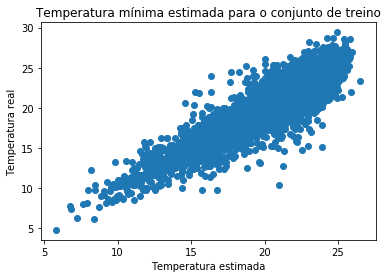

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.91932797]
 [0.91932797 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

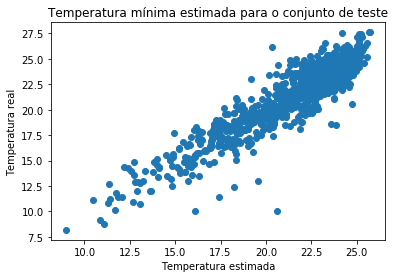

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.91825043]
 [0.91825043 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.9767853830622365


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

1.73336566617401


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaCuiabá.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaCuiabá.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))